In [1]:
#https://docs.mdanalysis.org/stable/documentation_pages/analysis/msd.html
import MDAnalysis as mda
import MDAnalysis.analysis.msd as msd
import matplotlib.pyplot as plt

import numpy as np
from scipy.stats import linregress
from sklearn.utils import resample
import statistics
from statistics import sqrt, stdev

In [2]:
# The trajectory need to be in unwrapped mode
u1 = mda.Universe('output1/topology.pdb',"output1/trajectory_unwrap.dcd")

## MSD 

In [3]:
# MSD of water
MSD1 = msd.EinsteinMSD(u1, select='byres (smarts [OH2])', msd_type='xyz', fft=True)
MSD1.run(step =5)

In [4]:
msd1 =  MSD1.results.timeseries

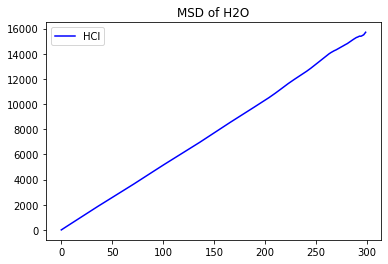

In [5]:
import matplotlib.pyplot as plt
nframes1 = MSD1.n_frames
timestep = 1 # this needs to be the actual time between frames
lagtimes1 = np.arange(nframes1)*timestep # make the lag-time axis
fig = plt.figure()
ax = plt.axes()
# plot the actual MSD
ax.plot(lagtimes1, msd1, 'b-', label=r'HCl')
ax.legend()
ax.set_title('MSD of H2O')
plt.show() 

### Diffusion Coefficient + Statistical Analysis

### Define functions

#### 1. block_average method
select the right block size for subsampling

In [6]:
def block_averaging(data, minBlockLen, maxBlockLen, step = 1):
    frame = len(data) # total frames in the trajectory
    numBlocks = maxBlockLen - minBlockLen # total number of block lengths
    blockMean = [] # container for block mean
    blockSVar = [] # container for block variance
    
    for blen in range(minBlockLen, maxBlockLen, step): 
        Nblock = frame // blen  # number of blocks for (block length = blen)
        Nmean = np.zeros(Nblock) # container means for each block when (block length = blen)
        for i in range(Nblock):
            begin = i * blen 
            end = begin + blen 
            Nmean[i] = np.mean(data[begin: end])
            
        blockMean.append(np.mean(data)) # get mean for each block length
        blockSVar.append(np.sqrt(np.var(Nmean)/(Nblock-1)))
        
# Plot error bar        
    x = np.arange(minBlockLen, maxBlockLen, step)
    plt.plot(x,blockMean)
    plt.errorbar(x,blockMean, blockSVar)
    print(blockMean[0])

#### 2. bootstrap the MSD (with the right sample size) and calculate the D

In [7]:
def boot_D(data,x, y,n_sample):
    D = []
    for i in range(1000): # repeat 1000 times bootstrapping
        sample = resample(data, replace=True, n_samples = 100)
        s = sample.sort_values(x)
        slope = (s[y].iloc[-1]-s[y].iloc[0])/(s[x].iloc[-1]-s[x].iloc[0])
        d = slope*1/(2*3) # dim_fac
        D.append(d)          
    return D

#### 3. plot confidence interval

In [8]:
def plot_confidence_interval(x, values, z, color='#2187bb', horizontal_line_width=0):
    mean = np.mean(values)
    confidence_interval = z * stdev(values)/sqrt(len(values)) 
    plt.errorbar(x, mean, confidence_interval, ecolor='gray', lw=2, capsize=5, capthick=2)
    plt.plot([x], mean,'o-r')
    return mean, confidence_interval

### Apply the statistical methods 

#### 1.Calculate self-diffusivity over time

In [9]:
MSD = msd.EinsteinMSD(u1,'byres (smarts [OH2])', msd_type='xyz', fft=True)
MSD.run()
msd_ls =  MSD.results.timeseries
nframes = MSD.n_frames
timestep = 1 # this needs to be the actual time (ns) between frames , 10 ps = 0.01 ns = 10^(-11)s
lagtimes = np.arange(nframes)*timestep # make the lag-time axis

slope = []
error = []
D1 = []
for start_time in range(nframes):
    start_index = int(start_time/timestep)
    end_index = start_index+5
    linear_model = linregress(lagtimes[start_index:end_index],msd_ls[start_index:end_index])
    slope.append(linear_model.slope)
    error.append(linear_model.rvalue)
    D1.append(linear_model.slope*1/(2*MSD.dim_fac))
        
# dim_fac is 3 as we computed a 3D msd with 'xyz'



/opt/anaconda3/envs/openmm/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/opt/anaconda3/envs/openmm/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/opt/anaconda3/envs/openmm/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:192: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


Text(0.5, 1.0, 'H2O Diffusion Coefficient')

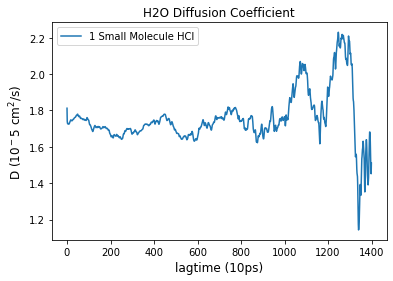

<Figure size 432x288 with 0 Axes>

In [10]:
ax = plt.axes()
fig = plt.figure()
ax.plot(np.arange(len(D1[:1400])), D1[:1400], label = '1 Small Molecule HCl')
ax.legend()
ax.set_xlabel('lagtime (10ps)', fontsize = 12)
ax.set_ylabel('D (10$^-5$ cm$^2$/s)', fontsize = 12)
ax.set_title('H2O Diffusion Coefficient', fontsize = 12)

#### 2. block averaging methods

1.7167923067636757


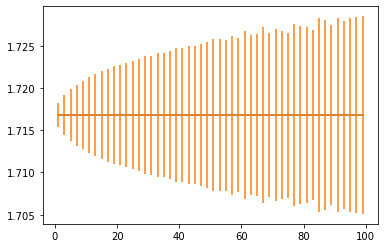

In [11]:
block_averaging(D1[:1000],1,100,step =2)

#### 3. bootstrapping to get water diffusivity

In [12]:
import pandas as pd
MSD1 = msd.EinsteinMSD(u1,'byres (smarts [OH2])', msd_type='xyz', fft=True)
MSD1.run()
MSD1_df = pd.DataFrame(MSD1.results.timeseries, columns = ['MSD'])
MSD1_df["Frames"] = np.arange(u1.trajectory.n_frames)+1
data1 = MSD1_df[:1000]

In [13]:
D1 = boot_D(data1,'Frames','MSD',100)

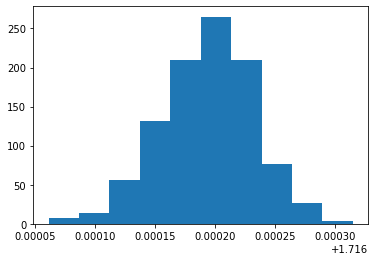

Text(0.95, 1.7161943500652275, 'mean = 1.7162\nconfidence interval\n= 0.00002425')

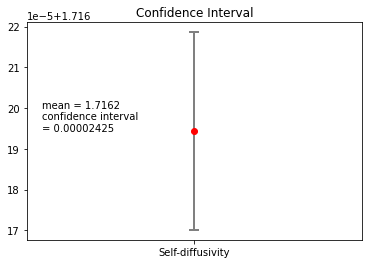

In [14]:
import matplotlib.pyplot as plt
import statistics
from statistics import sqrt, stdev
data = D1
Mean = []
Error = []
n_sample = 1000
for i in range(1000): # repeat 200 times bootstrapping
    bootstrap = resample(data, replace=True, n_samples = 100)
    # out of bag obervations
    oob = [x for x in data if x not in bootstrap]
    Mean.append(np.mean(bootstrap))
    Error.append(np.sqrt(np.var(bootstrap)/(n_sample-1)))

plt.hist(Mean)
plt.show()

mean1 = statistics.mean(data)
stdev1 = statistics.stdev(data)
z =1.96
ci1 = z * stdev1/sqrt(n_sample)
plt.xticks([1], ['Self-diffusivity'])
plt.title('Confidence Interval')
plt.errorbar(1, mean1, ci1, ecolor='gray', lw=2, capsize=5, capthick=2)
plt.plot([1], mean1,'o-r')
plt.text(0.95,mean1,f'mean = {mean1:.4f}\nconfidence interval\n= {ci1:.8f}')
